In [1]:
# 尝试als
# 初始化环境
import os
from os.path import *
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

file_dir = os.path.abspath(".")
proj_dir = dirname(dirname(file_dir))
os.environ['HADOOP_HOME'] = r"C:\hadoop\hadoop-2.6.5"
os.environ['SPARK_HOME'] = r"C:\hadoop\spark-2.4.5-bin-hadoop2.6"
os.environ['JAVA_HOME'] = r"C:\Program Files\Java\jdk1.8.0_191"
os.environ["SCALA_HOME"] = r"C:\Program Files (x86)\scala"
os.environ["PYSPARK_SUBMIT_ARGS"] = " --driver-memory 32g " \
                                    " --conf spark.driver.extraJavaOptions=-Xss1g " \
                                    " --conf spark.executor.extraJavaOptions=-Xss1g " \
                                    " pyspark-shell "
sconf = SparkConf().setMaster("local[12]").setAppName("test")
sc = SparkContext(conf=sconf)
ss = SparkSession(sparkContext=sc)
ss

In [2]:
# 加载数据集，sample_movielens_data第一列是用户id，第二列是电影id，第三列是评分
ml_test_data_dir = os.environ['SPARK_HOME'] + "\\data\\\mllib\\"
test_df = ss.read.csv(ml_test_data_dir + "sample_movielens_data.txt", sep=":",
                      schema="user INT, a STRING, movie INT, b STRING, rating INT")
test_df = test_df.select("user", "movie", "rating")
test_df.show()

+----+-----+------+
|user|movie|rating|
+----+-----+------+
|   0|    2|     3|
|   0|    3|     1|
|   0|    5|     2|
|   0|    9|     4|
|   0|   11|     1|
|   0|   12|     2|
|   0|   15|     1|
|   0|   17|     1|
|   0|   19|     1|
|   0|   21|     1|
|   0|   23|     1|
|   0|   26|     3|
|   0|   27|     1|
|   0|   28|     1|
|   0|   29|     1|
|   0|   30|     1|
|   0|   31|     1|
|   0|   34|     1|
|   0|   37|     1|
|   0|   41|     2|
+----+-----+------+
only showing top 20 rows



In [3]:
data_train, data_test = test_df.randomSplit([0.8, 0.2])
data_train.count(), data_test.count()

(1216, 285)

In [4]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def als_eva(maxIter=10,):
    als = ALS(maxIter=maxIter,
              regParam=0.01,
              userCol="user",
              itemCol="movie",
              ratingCol="rating",
              coldStartStrategy="drop")
    model = als.fit(data_train)  # 注意这里fit后必须接收才是有用的
    evaluator = RegressionEvaluator(metricName="rmse",  # 回归用的均方根误差
                                    labelCol="rating",
                                    predictionCol="prediction")
    train_loss = evaluator.evaluate(model.transform(data_train))/5 # 因为rating是1-5，所以差值除以5是实际的损失
    test_loss = evaluator.evaluate(model.transform(data_test))/5
    return train_loss, test_loss
als_eva(26)

(0.025302381638289927, 0.3024724029180222)

In [5]:
# 考虑不同的迭代次数后的数据：
eva_values = []
for i in range(1, 50, 3):
    train_loss, test_loss = als_eva(i)
    eva_values.append((str(i), train_loss, test_loss))
    print("iter=",str(i), train_loss, test_loss )

iter= 1 0.14345129470584497 0.470261704267701
iter= 4 0.0593534591499867 0.3790186178916417
iter= 7 0.04222492814897376 0.3654408673604032
iter= 10 0.03568697494278481 0.3469733967242659
iter= 13 0.03281750626842157 0.3330362192159368
iter= 16 0.031023425011171453 0.32227506079509083
iter= 19 0.029123758903125813 0.3134017875585196
iter= 22 0.02717732569500502 0.30752563783870734
iter= 25 0.025693785364706068 0.30350621982710246
iter= 28 0.02463740569489133 0.3007426942627747
iter= 31 0.02386650372224938 0.29878705672912076
iter= 34 0.023295388895745027 0.29732660661310056
iter= 37 0.02286329784104539 0.29611253461691267
iter= 40 0.022527990954071656 0.2949845190856292
iter= 43 0.022269101156541713 0.2938838098803961
iter= 46 0.022077334140957822 0.2928105712106015
iter= 49 0.021942084454327545 0.2917751541466339


In [6]:
import pandas as pd
draw_data = pd.DataFrame(eva_values)
draw_data

,0,1,2
0,1,0.143451,0.470262
1,4,0.059353,0.379019
2,7,0.042225,0.365441
3,10,0.035687,0.346973
4,13,0.032818,0.333036
5,16,0.031023,0.322275
6,19,0.029124,0.313402
7,22,0.027177,0.307526
8,25,0.025694,0.303506
9,28,0.024637,0.300743


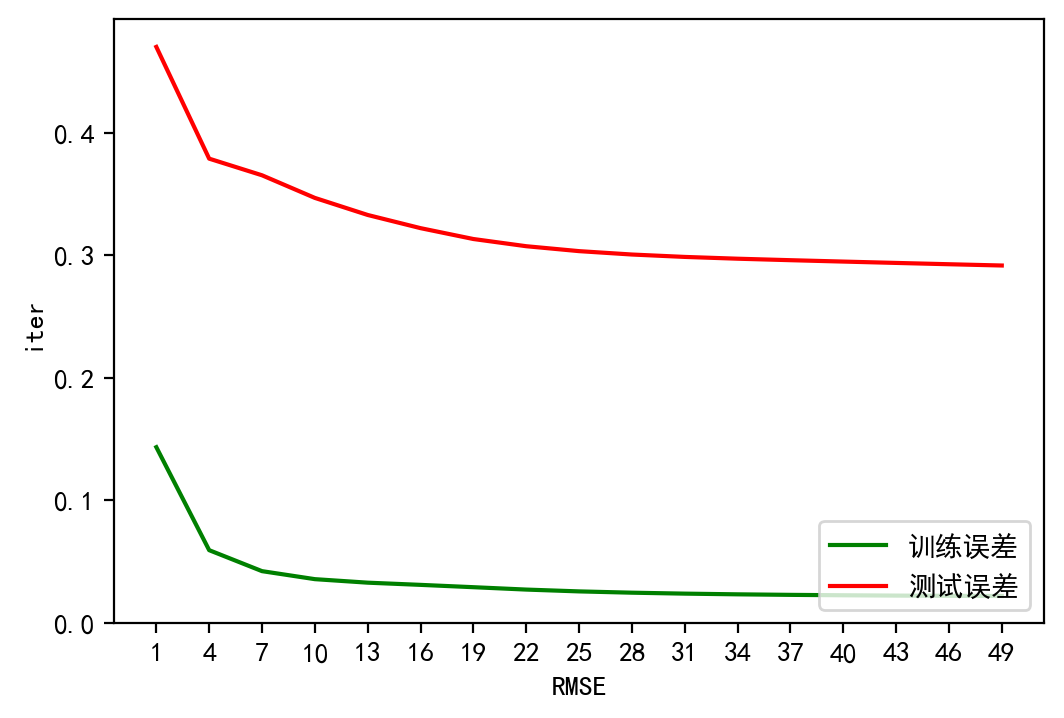

In [7]:
# 画出来
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['font.sans-serif'] = ['simhei']
matplotlib.rcParams['axes.unicode_minus'] = False
plt.plot(draw_data[0],draw_data[1], c='green')
plt.plot(draw_data[0],draw_data[2], c='red')
plt.xlabel("RMSE")
plt.ylabel("iter")
plt.legend(("训练误差","测试误差"),loc='lower right')
plt.show()

看这个情况，50次的iter还不够，效果只能是一般，如果是200次呢？

In [8]:
als_eva(200)

(0.02017882498205578, 0.294127937392933)

In [ ]:
ss.stop()